In [1]:
import nbimporter
import torch
import torch.nn as nn
import torch.nn.functional as f

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange
from IPython.display import clear_output
from torch.optim import Adam
from pogema_env import My_env

In [2]:
kernel_size = 3
padding = 1
in_ch = 3
hidden_sizes = [128, 128, 128, 256, 256, 128]
n_actions = 5

In [3]:
class Primal_network(nn.Module):
    def __init__(self, n_actions=n_actions, epsilon=0):
        super().__init__()
        self.epsilon = epsilon
        self.n_action = n_actions
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=hidden_sizes[0], kernel_size=kernel_size, padding=1),
            nn.Conv2d(in_channels=hidden_sizes[0], out_channels=hidden_sizes[1], kernel_size=kernel_size, padding=1),
            nn.Conv2d(in_channels=hidden_sizes[1], out_channels=hidden_sizes[2], kernel_size=kernel_size, padding=1),
        )
        
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        
        self.next_layers = nn.Sequential(
            nn.Conv2d(in_channels=hidden_sizes[2], out_channels=hidden_sizes[3], kernel_size=kernel_size, padding=1),
            nn.Conv2d(in_channels=hidden_sizes[3], out_channels=hidden_sizes[4], kernel_size=kernel_size, padding=1),
            nn.Conv2d(in_channels=hidden_sizes[4], out_channels=hidden_sizes[5], kernel_size=kernel_size, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=hidden_sizes[5], out_channels=512, kernel_size=2)
        )
        
        self.linear = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )
        
        self.lstm = nn.LSTM(512 * 2, 512)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(512, n_actions + 2)
        
    def forward(self, input_):
        # print(input_)
        # print("input.shape = ", input_.shape)
        out_res = self.conv_layers(input_)
        # print("First_conv = ", out_res.shape)
        out_res = self.max_pool(out_res)
        # print("Max_pool = ", out_res.shape)
        out_res = self.next_layers(out_res)
        out_res.squeeze_()
        # print("Second conv = ", out_res.shape)
        out = self.linear(out_res)
        # print("After_linear = ", out.shape)
        
        concat = torch.concatenate((out, out_res), dim=-1)
        # print("concatination = ", concat.shape)
        lstm_input = self.relu(concat)
        # print(lstm_input.shape)
        out, (_ , _) = self.lstm(lstm_input)
        # print("LSTM = ", out.shape)
        out = self.fc(out)
        # print(out.shape)
        return out[:, :n_actions], out[:, :n_actions], out[:, n_actions + 1]
    
    def get_action(self, state):
        logits, _, _ = self.forward(state)
        return torch.argmax(logits, -1)

In [4]:
pr = Primal_network()

In [5]:
inp = torch.ones(5, 3, 11, 11)
inp.shape, hidden_sizes[0], in_ch

(torch.Size([5, 3, 11, 11]), 128, 3)

In [6]:
pr(inp)

(tensor([[-0.0392,  0.0060, -0.0053,  0.0220,  0.0393],
         [-0.0406,  0.0078, -0.0088,  0.0198,  0.0416],
         [-0.0410,  0.0090, -0.0112,  0.0186,  0.0436],
         [-0.0411,  0.0096, -0.0128,  0.0179,  0.0449],
         [-0.0410,  0.0099, -0.0138,  0.0175,  0.0458]],
        grad_fn=<SliceBackward0>),
 tensor([[-0.0392,  0.0060, -0.0053,  0.0220,  0.0393],
         [-0.0406,  0.0078, -0.0088,  0.0198,  0.0416],
         [-0.0410,  0.0090, -0.0112,  0.0186,  0.0436],
         [-0.0411,  0.0096, -0.0128,  0.0179,  0.0449],
         [-0.0410,  0.0099, -0.0138,  0.0175,  0.0458]],
        grad_fn=<SliceBackward0>),
 tensor([-0.0317, -0.0244, -0.0193, -0.0159, -0.0138],
        grad_fn=<SelectBackward0>))

In [7]:
def compute(agent, n_agents, states, rewards, is_done, gamma=0.99):
    logits, v_value, blocking = agent(states)
    
    is_done = is_done.reshape(n_agents, -1)
    rewards = rewards.reshape(n_agents, -1)
    v_value = rewards.reshape(n_agents, -1)
    # logits = logits.reshape(n_agents, -1, agent.n_action)
    # print(is_done.shape, v_value.shape, logits.shape, rewards.shape)    
    
    
    # backward_rewards = (1 - is_done[-1]) * v_value[:, -1]
    
    ln, time = rewards.shape[-2:]
    
    r = (1 - is_done[:, -1]) * rewards[:, -1] + v_value[:, -1]
    result = torch.zeros(rewards.shape)
    result[:, time - 1] = r
    for t in range(time - 2, -1, -1):
        r = rewards[:, t] + gamma * (1 - is_done[:, t]) * r 
        result[:, t] = r
                
    return result, logits, v_value, blocking

In [8]:
def compute_loss(agent, env, states, actions, rewards, next_s, is_done, entropy_coef=.01, value_loss_coef=.3):
    # TODO: Blocking loss
    # states = torch.Tensor(states)
    # actions = torch.Tensor(actions)
    # next_s = torch.Tensor(next_s)
    # rewards = torch.Tensor(rewards)
    # is_done = torch.Tensor(is_done)
    # actions = actions.reshape(env.n_agents, -1)
    # print(states.shape, actions.shape, rewards.shape, next_s.shape, is_done.shape)
    rewards, logits, v_value, blocking = compute(agent, env.n_agents, states, rewards, is_done)
    
    rewards = rewards.detach()
    
    probs = f.softmax(logits, dim=-1)
    logprobs = f.log_softmax(logits, dim=-1)
    
    advantage = (rewards - v_value).detach()
    
    
    # print(f"rewards,shape = {rewards.shape}  logits.shape = {logits.shape}, logprobs.shape = {logprobs.shape}")
    logprobs_for_action = logprobs[range(len(actions)), actions]
    logprobs_for_action = logprobs_for_action.reshape(env.n_agents, -1)
    
    
    
    entropy = -(probs * logprobs).sum(1).mean()
    # print(f"logprobs_for_action = {logprobs_for_action.shape}, advantage = {advantage.shape}")
    value_loss = torch.mean((rewards - v_value) ** 2)
    
    policy_loss = -(logprobs_for_action * advantage).mean()
    
    loss = value_loss_coef * value_loss + policy_loss - entropy_coef * entropy
    
    return loss, value_loss, policy_loss

In [9]:
primal = Primal_network()
optimizer =  Adam(pr.parameters(), lr=7e-4, eps=1e-5)

env = My_env()
state = env.reset()

pogema_env.ipynb:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  "id": "b66d0188",


In [10]:
def run_episode(env, agent, state, t_max=30):
    states = []
    actions = []
    rewards = []
    next_states = []
    is_dones = []
    for i in range(t_max):
        action = agent.get_action(state)
        next_state, reward, is_done, info = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        is_dones.extend(is_done)
        
        if sum(is_done) == env.n_agents:
            state = env.reset()
        else:
            state = next_state
            
    last_state = next_states[-1]
    states = torch.concatenate(states, 0)
    actions = torch.concatenate(actions, 0)
    rewards = torch.concatenate(rewards, 0)
    next_states = torch.concatenate(next_states, 0)
    is_dones = torch.Tensor(is_dones)
    # print(states.shape, actions.shape, rewards.shape, next_states.shape, is_dones.shape)
    return states, actions, rewards, next_states, is_dones, last_state

In [11]:
primal = Primal_network()
optimizer =  Adam(pr.parameters(), lr=1e-4)

state = env.reset()

step = 0
total_steps = 10 ** 3

history_loss = []
history_value_loss = []
history_policy_loss = []

history_update_freq = 10

type(state)

torch.Tensor

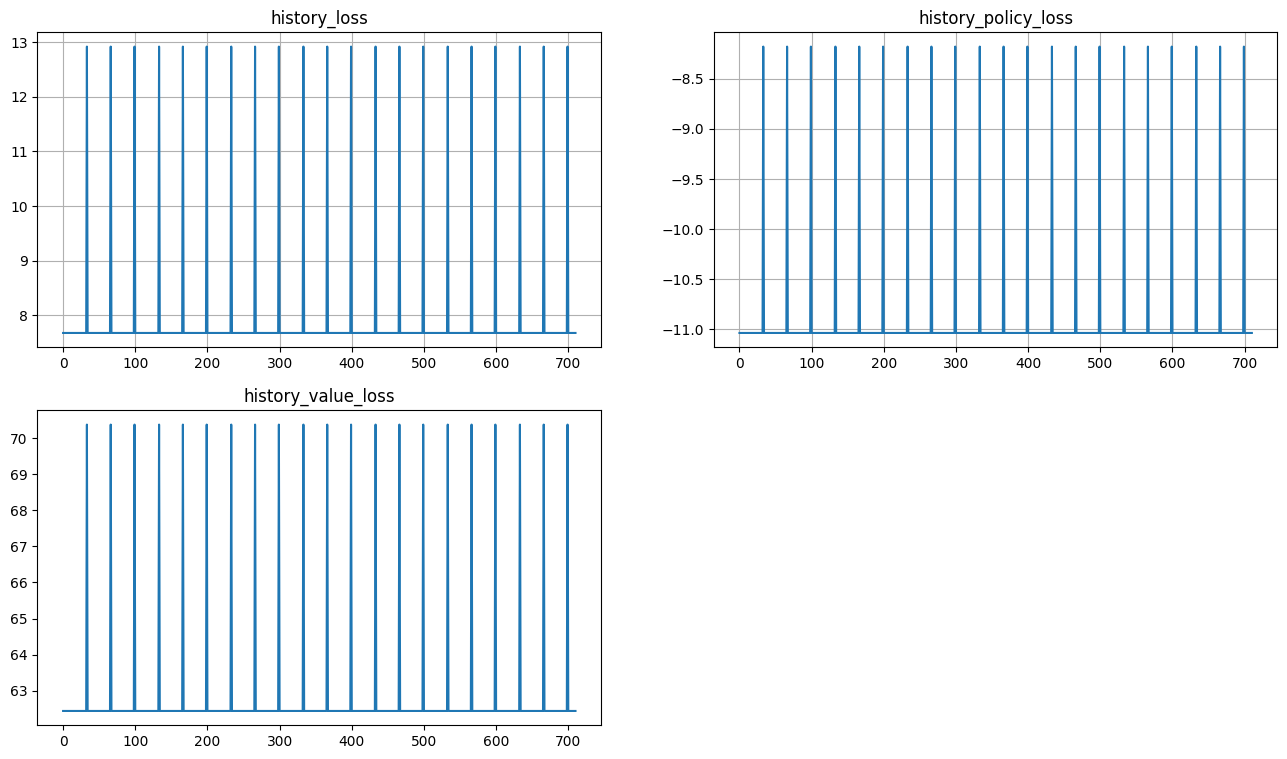

 71%|████████████████████████████████████████████████████████▎                      | 713/1001 [13:31<04:53,  1.02s/it]

In [ ]:
with trange(step, total_steps + 1, 1) as progress_bar:
    for step in progress_bar:
        
        states, actions, rewards, next_states, is_done, state  = run_episode(env, primal, state)
        
        optimizer.zero_grad()
        
        loss, value_loss, policy_loss = compute_loss(primal, env, states, actions, rewards, next_states, is_done)
        
        loss.backward()
        
        optimizer.step()
        history_loss.append(loss.item())
        history_policy_loss.append(policy_loss.item())
        history_value_loss.append(value_loss.item())
        
        with torch.no_grad():
            if step % history_update_freq == 0:
                
                clear_output()
                plt.figure(figsize=[16, 9])

                plt.subplot(2, 2, 1)
                plt.title("history_loss")
                plt.plot(history_loss)
                plt.grid()

                plt.subplot(2, 2, 2)
                plt.title("history_policy_loss")
                plt.plot(history_policy_loss)
                plt.grid()

                plt.subplot(2, 2, 3)
                plt.title("history_value_loss")
                plt.plot(history_value_loss)    

                plt.show()